## setup

In [1]:
! pip install tensorflow numpy matplotlib torch torchvision pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

## Tensorflow

### Transformation Feature Extractor

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


print("TensorFlow version:", tf.__version__)


# Build Transformation Feature Extractor

def build_dtn(input_shape=(500, 500, 3), tf_channels=12, backbone="resnet", k=4):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for i in range(k):
        if backbone == "resnet":
            shortcut = x
            # 🛠 Match channel dimensions using 1x1 conv
            if x.shape[-1] != 64:
                shortcut = layers.Conv2D(64, 1, padding='same')(shortcut)

            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Conv2D(64, 3, padding='same')(x)
            x = layers.Add()([shortcut, x])
            x = layers.ReLU()(x)
        elif backbone == "densenet":
            dense_input = x
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
            x = layers.Concatenate()([dense_input, x])
        else:  # plain CNN
            x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

        x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(tf_channels, 1, padding='same')(x)
    model = models.Model(inputs, x, name=f"DTN_{backbone}_k{k}")
    return model


# Build Expected Texture Transformer

def expected_texture_transformer(tf_features, eta_exp):
    subtractor = tf_features[..., 0:3]
    adder1 = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2 = tf_features[..., 9:12]

    x = (eta_exp - subtractor)
    x = x + adder1
    x = x * multiplier
    x = x + adder2
    return x


# Define Training Loop

def train_dtn(x_ref, eta_exp, x_ren, epochs=5, batch_size=16, backbone="resnet", k=4):
    dtn_model = build_dtn(backbone=backbone, k=k)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    dataset = tf.data.Dataset.from_tensor_slices((x_ref, eta_exp, x_ren))
    dataset = dataset.shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_xref, batch_etaexp, batch_xren in dataset:
            with tf.GradientTape() as tape:
                tf_features = dtn_model(batch_xref, training=True)

                tf_features = tf.image.resize(tf_features, size=(batch_etaexp.shape[1], batch_etaexp.shape[2]), method='bilinear')

                x_recon = expected_texture_transformer(tf_features, batch_etaexp)
                loss = loss_fn(batch_xren, x_recon)

            grads = tape.gradient(loss, dtn_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, dtn_model.trainable_weights))
            epoch_loss += loss.numpy()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    return dtn_model


# Real Data Loading (From Files)

def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

# Example folder structure
# /content/
#   ref_images/  --> x_ref (masked rendered object images)
#   exp_textures/ --> eta_exp (expected textures, flat color masked images)
#   ren_images/ --> x_ren (ground truth rendered images)

real_data = False

# You can upload and load your real datasets if available
if os.path.exists('dataset/reference'):
    print("Loading real datasets...")
    x_ref = load_images_from_folder('dataset/reference')
    eta_exp = load_images_from_folder('dataset/texture')
    x_ren = load_images_from_folder('dataset/rendered')
    real_data = True
else:
    print("Real data folders not found. Using dummy random data...")
    num_samples = 100
    x_ref = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    eta_exp = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)
    x_ren = np.random.rand(num_samples, 500, 500, 3).astype(np.float32)

print("Data loaded:", x_ref.shape, eta_exp.shape, x_ren.shape)


# Train DTN Model

print("\nStarting DTN Training...")
trained_model = train_dtn(x_ref, eta_exp, x_ren, epochs=25, batch_size=32, backbone="resnet", k=4)


# Save Model
trained_model.save("dtn_model_real.h5")
print("\nModel saved as dtn_model_real.h5 ")



In [13]:
# Visualize TF and Reconstruction Output

# Visualize 5 Random Predictions
num_visuals = 5
indices = np.random.choice(len(x_ref), size=num_visuals, replace=False)

plt.figure(figsize=(16, num_visuals * 2))

for i, idx in enumerate(indices):
    sample_xref = x_ref[idx:idx+1]
    sample_etaexp = eta_exp[idx:idx+1]
    sample_xren = x_ren[idx:idx+1]

    tf_features = trained_model.predict(sample_xref)
    tf_features = tf.image.resize(tf_features, size=(sample_etaexp.shape[1], sample_etaexp.shape[2]), method='bilinear')
    recon = expected_texture_transformer(tf_features, sample_etaexp).numpy()

    # Split TF into 4 RGB maps
    subtractor = tf_features[..., 0:3]
    adder1     = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2     = tf_features[..., 9:12]

    feature_maps = [subtractor, adder1, multiplier, adder2]
    titles = ['TF: Subtractor', 'TF: Adder1', 'TF: Multiplier', 'TF: Adder2']

    # # Plot
    # plt.figure(figsize=(12, 4))
    # for j in range(4):
    #     plt.subplot(1, 4, j+1)
    #     # Clip values to [0,1] to visualize
    #     plt.imshow(np.clip(feature_maps[j][0], 0, 1))
    #     plt.title(titles[j])
    #     plt.axis('off')
    # plt.suptitle("Visualizing the 4 Stacked RGB Transformation Features from DTN Output", fontsize=14)
    # plt.tight_layout()
    # plt.show()

    # Plot 4 columns: x_ref, eta_exp, x_ren, recon
    for j, img in enumerate([sample_xref[0], sample_etaexp[0], sample_xren[0], recon[0]]):
        plt.subplot(num_visuals, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(["x_ref", "eta_exp", "x_ren", "recon"][j])

plt.suptitle("DTN Reconstruction Results on 5 Random Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'trained_model' is not defined

<Figure size 1600x1000 with 0 Axes>

## plain nn

In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



2025-07-02 10:17:15.227573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 10:17:15.380926: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 10:17:15.405194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-02 10:17:15.405201: I tensorflow/compiler

In [3]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [29]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...


(1030, 500, 500, 3)


In [5]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(
            [x_ref[:1025], eta_exp[:1025]], 
            x_ren[:1025], 
            epochs=25, 
            batch_size=16, 
            validation_split=0.1, 
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        )
# early stopping disable for structure 4

2025-06-26 18:39:32.407631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-26 18:39:32.407779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-06-26 18:39:32.407818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-06-26 18:39:32.407849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared o

Epoch 1/25
58/58 [==============================] - 237s 4s/step - loss: 0.0347 - accuracy: 0.0302 - val_loss: 0.0014 - val_accuracy: 0.0148
Epoch 2/25
58/58 [==============================] - 237s 4s/step - loss: 0.0010 - accuracy: 0.0146 - val_loss: 0.0011 - val_accuracy: 0.0156
Epoch 3/25
58/58 [==============================] - 236s 4s/step - loss: 7.5166e-04 - accuracy: 0.0182 - val_loss: 7.2188e-04 - val_accuracy: 0.0215
Epoch 4/25
58/58 [==============================] - 236s 4s/step - loss: 5.2586e-04 - accuracy: 0.0224 - val_loss: 5.9054e-04 - val_accuracy: 0.0264
Epoch 5/25
58/58 [==============================] - 236s 4s/step - loss: 4.0910e-04 - accuracy: 0.0255 - val_loss: 4.7256e-04 - val_accuracy: 0.0261
Epoch 6/25
58/58 [==============================] - 239s 4s/step - loss: 3.8191e-04 - accuracy: 0.0263 - val_loss: 4.6642e-04 - val_accuracy: 0.0274
Epoch 7/25
58/58 [==============================] - 236s 4s/step - loss: 3.6128e-04 - accuracy: 0.0265 - val_loss: 4.3165e

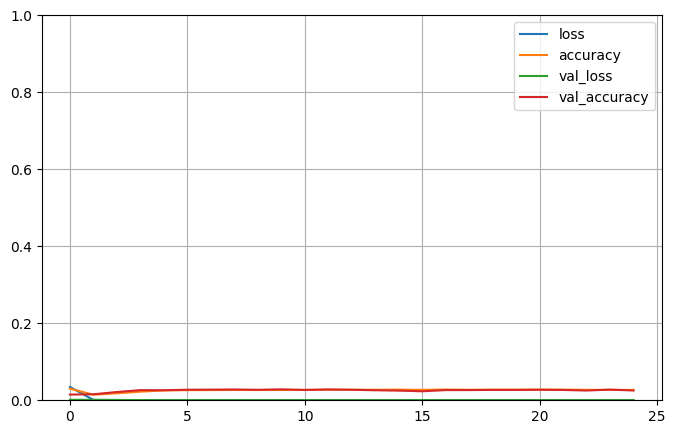

In [6]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Validation on val_dataset

In [7]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [8]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 5s 2s/step
Average MSE:  0.00041945712


1/1 [==============================] - 0s 380ms/step


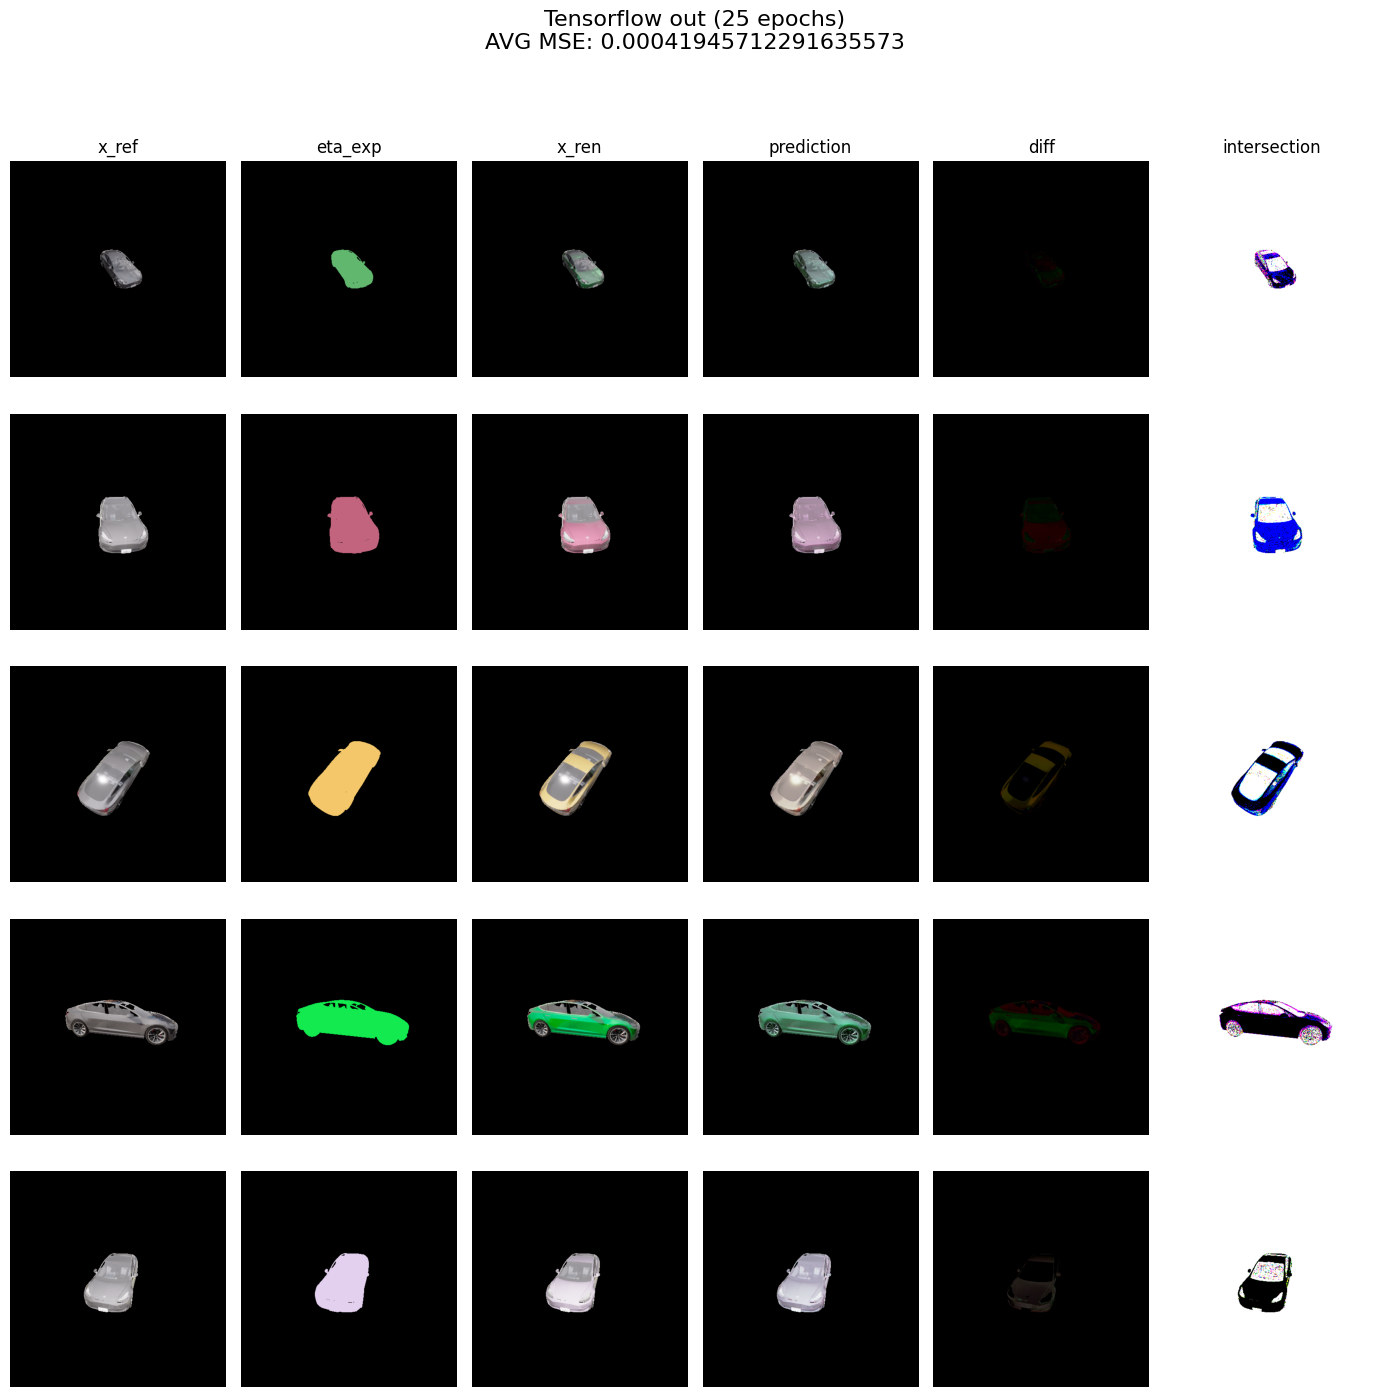

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

diff = x_ren[1025:] - preds

# Intersection mask (where rendered and reference are the same)
# For floating point images, use np.isclose with a tolerance
intersection = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "diff", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        diff[i],
        intersection[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (25 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## features

In [3]:
import numpy as np
import cv2

def generate_feature_maps_from(x_rgb):
    """
    Generate 12-channel feature maps from a 3-channel RGB image batch.
    x_rgb: numpy array of shape (N, H, W, 3)
    Returns: numpy array of shape (N, H, W, 12)
    """
    N, H, W, C = x_rgb.shape
    assert C == 3, "Input must have 3 channels (RGB)."
    
    feature_maps = []
    
    for i in range(N):
        img = x_rgb[i]
        img = (img * 255).astype(np.uint8)  # if normalized, revert to [0, 255]

        # 1-3: Original RGB
        r, g, b = img[..., 0], img[..., 1], img[..., 2]

        # 4: Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 5-6: Sobel edges
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # 7: Magnitude of gradient
        sobel_mag = np.sqrt(sobelx**2 + sobely**2)

        # 8-10: Gaussian blurs
        blur_1 = cv2.GaussianBlur(gray, (3, 3), 0)
        blur_2 = cv2.GaussianBlur(gray, (5, 5), 0)
        blur_3 = cv2.GaussianBlur(gray, (7, 7), 0)

        # Normalize all maps and stack
        def norm(x): return cv2.normalize(x, None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

        stacked = np.stack([
            norm(r), norm(g), norm(b),
            norm(gray),
            norm(sobelx), norm(sobely),
            norm(sobel_mag),
            norm(blur_1), norm(blur_2), norm(blur_3)
        ], axis=-1)  # shape (H, W, 10)

        # 11-12: mean + std image (broadcasted)
        img_mean = np.mean(img, axis=-1, keepdims=True) / 255.0
        img_std = np.std(img, axis=-1, keepdims=True) / 255.0

        stacked = np.concatenate([stacked, img_mean, img_std], axis=-1)  # shape (H, W, 12)

        feature_maps.append(stacked)

    return np.array(feature_maps, dtype=np.float32)


In [4]:
import numpy as np
import cv2

def generate_rgb_style_features(x_rgb):
    """
    Generate 12-channel features: 4 types of 3-channel color features.
    Input:
        x_rgb: numpy array of shape (N, H, W, 3), values in [0, 1] or [0, 255]
    Output:
        numpy array of shape (N, H, W, 12)
    """
    N, H, W, C = x_rgb.shape
    assert C == 3, "Input must have 3 channels (RGB)."
    is_normalized = x_rgb.max() <= 1.0

    feature_maps = []

    for i in range(N):
        img = x_rgb[i]
        if is_normalized:
            img = (img * 255).astype(np.uint8)

        # 1-3: Original RGB
        rgb = img.astype(np.float32)

        # 4-6: HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)

        # 7-9: YCbCr
        ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb).astype(np.float32)

        # 10-12: LAB
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float32)

        # Stack into (H, W, 12)
        stacked = np.concatenate([
            rgb,
            hsv,
            ycbcr,
            lab
        ], axis=-1) / 255.0  # normalize to [0, 1]

        feature_maps.append(stacked)

    return np.array(feature_maps, dtype=np.float32)


In [6]:
def build_simple_tf(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(12, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


#x_ren_12 = [generate_feature_maps_from(x_ren)]
#x_ren_12 = [generate_rgb_style_features(x_ren)]



In [7]:
def load_12channel_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)

    return generate_rgb_style_features(np.array(images))

def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren_12 = load_12channel_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [8]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model_tf = build_simple_tf(input_shape=(500, 500, 3))

model_tf.compile(optimizer='adam', 
                loss='mse', 
                # metrics=['accuracy']
                 )

history = model_tf.fit(
            [x_ref[:1025], eta_exp[:1025]], 
            x_ren_12[:1025], 
            epochs=25, 
            batch_size=4, 
            validation_split=0.1, 
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        )
# early stopping disable for structure 4

2025-07-02 00:14:00.752307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-02 00:14:00.752566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64
2025-07-02 00:14:00.752629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lunet/bz0192/.conda/envs/PROJECT/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64
2025-07-02 00:14:00.752754: W tensorflo

Epoch 1/25
231/231 [==============================] - 160s 691ms/step - loss: 0.0092 - val_loss: 8.5469e-04
Epoch 2/25
231/231 [==============================] - 159s 689ms/step - loss: 6.2258e-04 - val_loss: 8.7665e-04
Epoch 3/25
231/231 [==============================] - 159s 689ms/step - loss: 5.2296e-04 - val_loss: 6.9613e-04
Epoch 4/25
231/231 [==============================] - 159s 689ms/step - loss: 4.7481e-04 - val_loss: 5.7146e-04
Epoch 5/25
231/231 [==============================] - 159s 690ms/step - loss: 4.4534e-04 - val_loss: 5.4477e-04
Epoch 6/25
231/231 [==============================] - 159s 689ms/step - loss: 4.4579e-04 - val_loss: 5.5866e-04
Epoch 7/25
231/231 [==============================] - 160s 692ms/step - loss: 4.2303e-04 - val_loss: 5.3999e-04
Epoch 8/25
231/231 [==============================] - 159s 690ms/step - loss: 4.1621e-04 - val_loss: 5.1532e-04
Epoch 9/25
231/231 [==============================] - 159s 688ms/step - loss: 4.1554e-04 - val_loss: 5.2644e

1/1 [==============================] - 0s 228ms/step


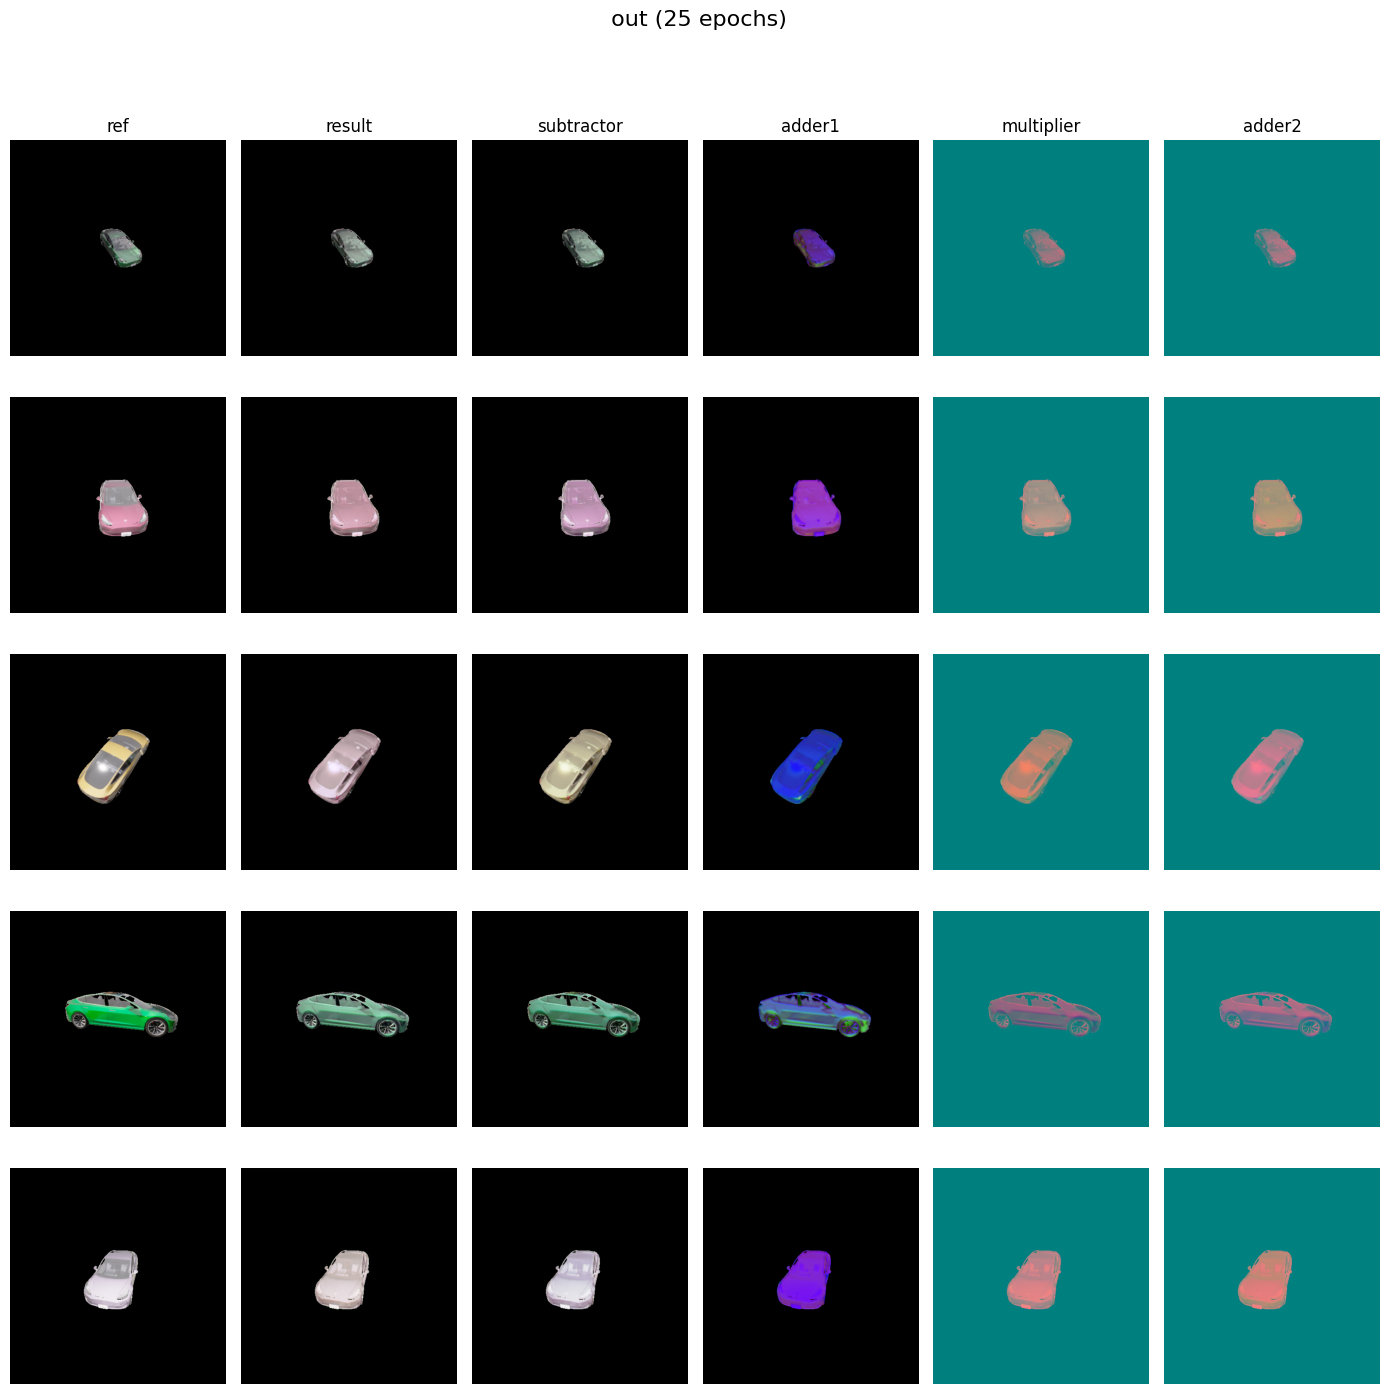

In [38]:
 
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model_tf.predict([x_ref[1025:], eta_exp[1025:]])

subtractor = preds[..., 0:3]
adder1 = preds[..., 3:6]
multiplier = preds[..., 6:9]
adder2 = preds[..., 9:12]

num_samples = 5
titles = ["ref", "result", "subtractor", "adder1", "multiplier", "adder2"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ren[1025+i],
        subtractor[i]  - multiplier[i] + adder2[i],
        subtractor[i],
        adder1[i],
        multiplier[i],
        adder2[i],
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f" out (25 epochs)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
def expected_texture_transformer(tf_features, eta_exp):
    print(tf_features.shape, eta_exp.shape)
    subtractor = tf_features[..., 0:3]
    adder1 = tf_features[..., 3:6]
    multiplier = tf_features[..., 6:9]
    adder2 = tf_features[..., 9:12]

    x = (eta_exp - subtractor)
    x = x + adder1
    x = x * multiplier
    x = x + adder2
    return x


tf_features = model_tf(x_ref_12[1025:], training=True)

print("TF Features shape:", tf_features.shape)

# Resize tf_features to match eta_exp shape

#tf_features = tf.image.resize(tf_features, size=(eta_exp.shape[1], eta_exp.shape[2]), method='bilinear')
#print("Resized TF Features shape:", tf_features.shape)


NameError: name 'x_ref_12' is not defined

In [ ]:
# Visualize TF and Reconstruction Output

# Visualize 5 Random Predictions
num_visuals = 5
indices = np.random.choice(len(x_ref), size=num_visuals, replace=False)

plt.figure(figsize=(16, num_visuals * 2))

for i, idx in enumerate(indices):
    sample_xref = x_ref[idx:idx+1]
    sample_etaexp = eta_exp[idx:idx+1]
    sample_xren = x_ren[idx:idx+1]

    tf_features = model_tf.predict(sample_xref)
    tf_features = tf.image.resize(tf_features, size=(sample_etaexp.shape[1], sample_etaexp.shape[2]), method='bilinear')
    recon = expected_texture_transformer(tf_features, sample_etaexp).numpy()

    # Split TF into 4 RGB maps
    #subtractor = tf_features[..., 0:3]
    #adder1     = tf_features[..., 3:6]
    #multiplier = tf_features[..., 6:9]
    #adder2     = tf_features[..., 9:12]

    #feature_maps = [subtractor, adder1, multiplier, adder2]
    #titles = ['TF: Subtractor', 'TF: Adder1', 'TF: Multiplier', 'TF: Adder2']

    # # Plot
    # plt.figure(figsize=(12, 4))
    # for j in range(4):
    #     plt.subplot(1, 4, j+1)
    #     # Clip values to [0,1] to visualize
    #     plt.imshow(np.clip(feature_maps[j][0], 0, 1))
    #     plt.title(titles[j])
    #     plt.axis('off')
    # plt.suptitle("Visualizing the 4 Stacked RGB Transformation Features from DTN Output", fontsize=14)
    # plt.tight_layout()
    # plt.show()

    # Plot 4 columns: x_ref, eta_exp, x_ren, recon
    for j, img in enumerate([sample_xref[0], sample_etaexp[0], sample_xren[0], recon[0]]):
        plt.subplot(num_visuals, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(["x_ref", "eta_exp", "x_ren", "recon"][j])

plt.suptitle("DTN Reconstruction Results on 5 Random Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1/1 [==============================] - 0s 59ms/step
(1, 500, 500, 3) (1, 500, 500, 3)


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1,500,500,3] vs. [1,500,500,0] [Op:AddV2]

<Figure size 1600x1000 with 0 Axes>

1/1 [==============================] - 1s 865ms/step


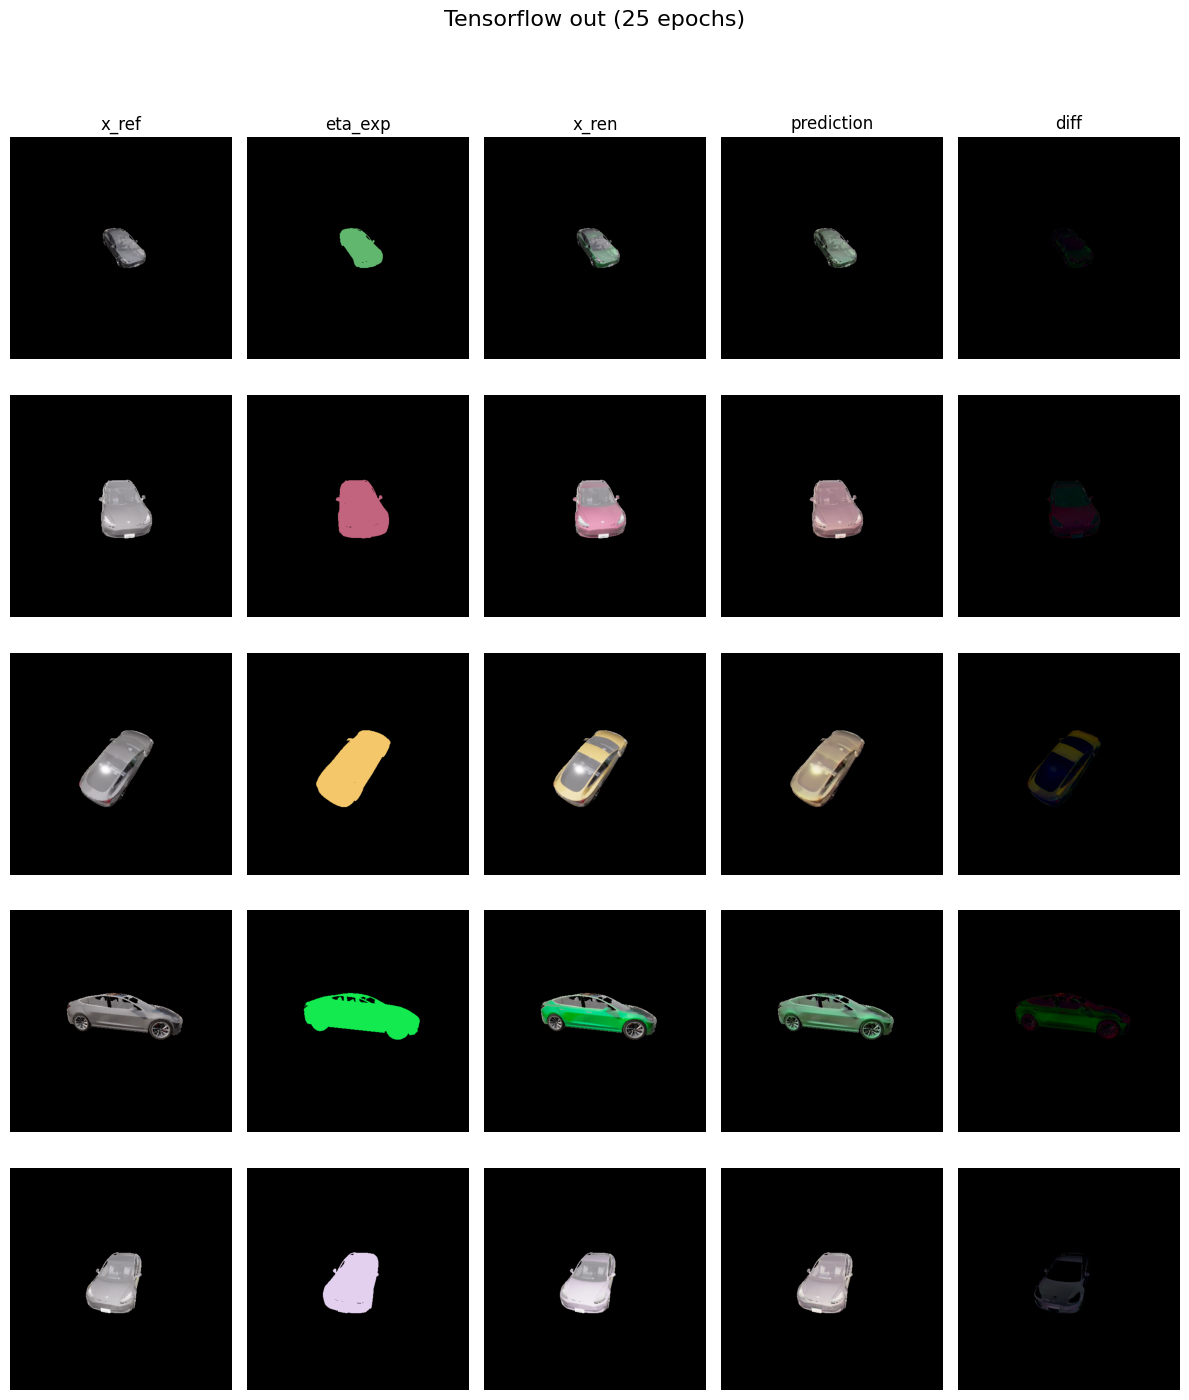

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

diff = x_ren[1025:] - preds

# Plot 5 rows × 4 columns (x_ref, eta_exp, x_ren, prediction)
num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "diff"]

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    images = [x_ref[i+1025], eta_exp[i+1025], x_ren[i+1025], preds[i], diff[i]]
    for j in range(5):
        plt.subplot(num_samples, 5, i * 5 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1))
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle("Tensorflow out (25 epochs)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

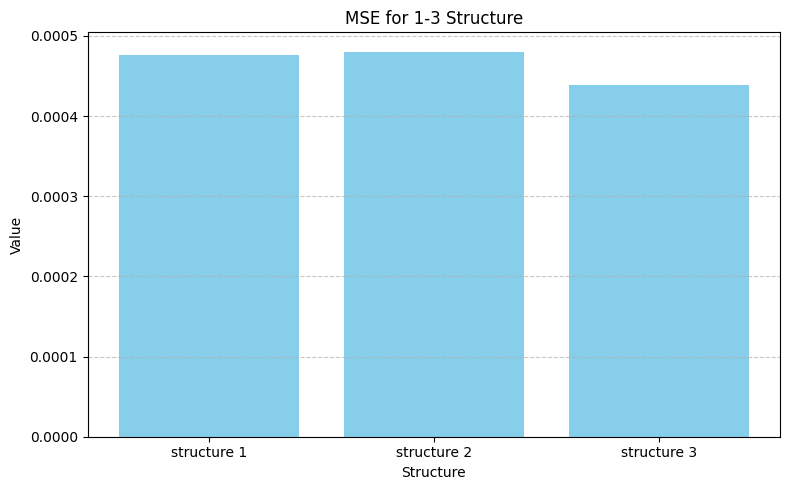

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV
df = pd.read_csv('experiments/1000+ dataset/average_mse.csv')

# Filter for structures 1, 2, 3 only
df = df[df['structure'].isin(['structure 1', 'structure 2', 'structure 3'])]


# Plotting
plt.figure(figsize=(8, 5))
plt.bar(df['structure'], df['average_mse'], color='skyblue')
plt.xlabel('Structure')
plt.ylabel('Value')
plt.title('MSE for 1-3 Structure')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## differences

### dataset generation

In [7]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)  # stays in [0, 255] as float32
        images.append(img)
    return np.array(images), paths


def save_images_from_array(images, save_folder, original_paths):
    os.makedirs(save_folder, exist_ok=True)
    for i, img in enumerate(images):
        # Clip to valid range and convert to uint8
        img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8)
        
        filename = os.path.basename(original_paths[i])
        img_pil.save(os.path.join(save_folder, filename))


print("Loading datasets...")
x_ref, ref_paths = load_images_from_folder('diff_dataset1/reference')
x_ren, ren_paths = load_images_from_folder('diff_dataset1/rendered')
eta_exp, eta_paths = load_images_from_folder('diff_dataset1/texture')


print("Subtracting reference from rendered...")
x_diff = x_ren - x_ref  # still float32, values now in [-255, 255]

print("Saving difference images to 'x_ren_ref_diff/'...")
save_images_from_array(x_diff, 'diff_dataset1/x_ren_ref_diff', ren_paths)

print("Done.")

print("Loading datasets...")
x_ref, ref_paths = load_images_from_folder('diff_dataset2/reference')
x_ren, ren_paths = load_images_from_folder('diff_dataset2/rendered')
eta_exp, eta_paths = load_images_from_folder('diff_dataset2/texture')


print("Subtracting reference from rendered...")
x_diff = x_ren - eta_exp  # still float32, values now in [-255, 255]

print("Saving difference images to 'x_ren_ref_diff/'...")
save_images_from_array(x_diff, 'diff_dataset2/x_ren_ref_diff', ren_paths)

print("Done.")


Loading datasets...
Subtracting reference from rendered...
Saving difference images to 'x_ren_ref_diff/'...
Done.
Loading datasets...
Subtracting reference from rendered...
Saving difference images to 'x_ren_ref_diff/'...
Done.


### x_ren - x_ref

In [4]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [5]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('diff_dataset1/reference')
eta_exp = load_images_from_folder('diff_dataset1/texture')
x_ren = load_images_from_folder('diff_dataset1/rendered')
x_ren_ref_diff = load_images_from_folder('diff_dataset1/x_ren_ref_diff')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [6]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(
            [x_ref[:1025], eta_exp[:1025]], 
            x_ren_ref_diff[:1025], 
            epochs=25, 
            batch_size=16, 
            validation_split=0.1, 
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        )
# early stopping disable for structure 4

2025-07-02 10:21:57.255760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-02 10:21:57.256022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-02 10:21:57.256086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-02 10:21:57.256130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared o

Epoch 1/25
58/58 [==============================] - 239s 4s/step - loss: 0.0257 - accuracy: 0.6256 - val_loss: 2.1998e-04 - val_accuracy: 0.9723
Epoch 2/25
58/58 [==============================] - 237s 4s/step - loss: 1.9689e-04 - accuracy: 0.9717 - val_loss: 2.1998e-04 - val_accuracy: 0.9743
Epoch 3/25
58/58 [==============================] - 237s 4s/step - loss: 1.9689e-04 - accuracy: 0.9720 - val_loss: 2.1998e-04 - val_accuracy: 0.9743
Epoch 4/25
58/58 [==============================] - 237s 4s/step - loss: 1.9689e-04 - accuracy: 0.9720 - val_loss: 2.1998e-04 - val_accuracy: 0.9743
Epoch 5/25
58/58 [==============================] - 237s 4s/step - loss: 1.9689e-04 - accuracy: 0.9720 - val_loss: 2.1998e-04 - val_accuracy: 0.9743
Epoch 6/25
58/58 [==============================] - 240s 4s/step - loss: 1.9689e-04 - accuracy: 0.9720 - val_loss: 2.1998e-04 - val_accuracy: 0.9743
Epoch 7/25
58/58 [==============================] - 236s 4s/step - loss: 1.9689e-04 - accuracy: 0.9720 - val_l

1/1 [==============================] - 0s 411ms/step


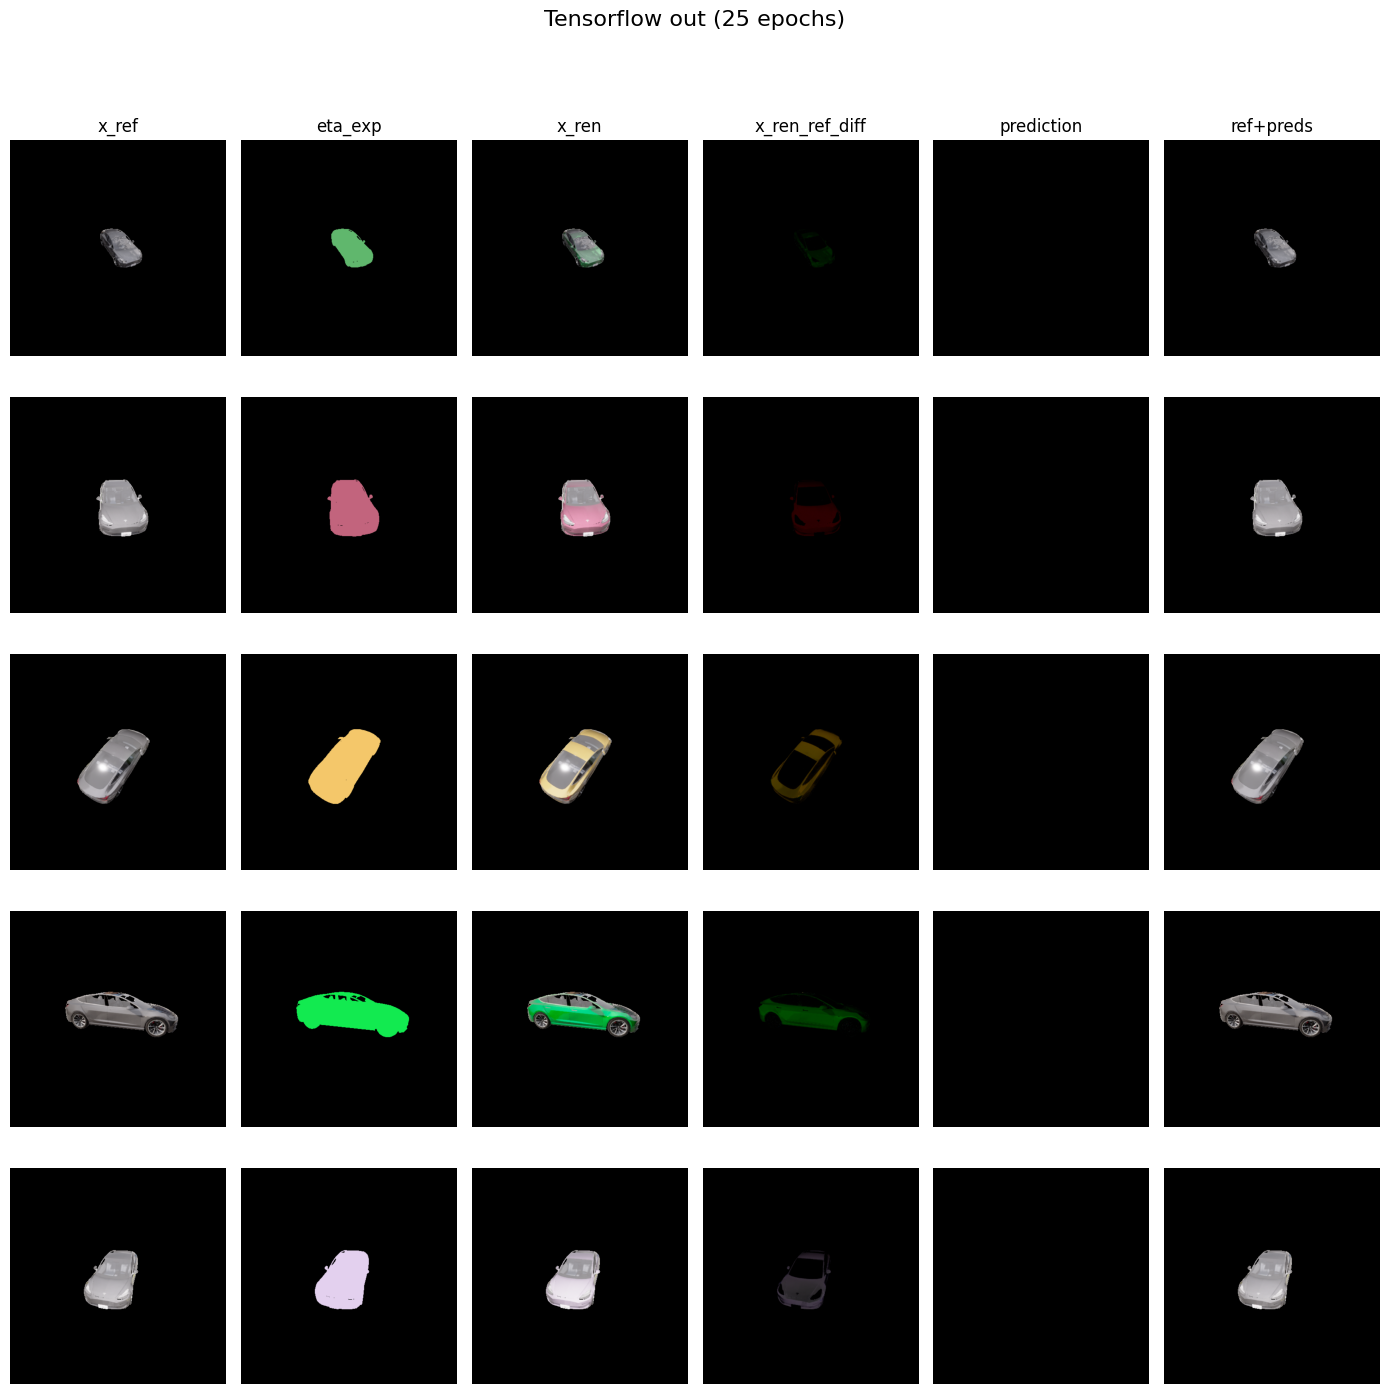

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

diff = x_ref[1025:] + preds

# Intersection mask (where rendered and reference are the same)
# For floating point images, use np.isclose with a tolerance
#intersection = np.isclose(x_ren_ref_diff[1025:], x_ref[1025:], atol=1e-2)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "x_ren_ref_diff", "prediction", "ref+preds"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        x_ren_ref_diff[i+1025],
        preds[i],
        diff[i],
  #     intersection[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (25 epochs)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### x_ren - eta_exp

In [13]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)  # Output 3 channels

    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [14]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('diff_dataset2/reference')
eta_exp = load_images_from_folder('diff_dataset2/texture')
x_ren = load_images_from_folder('diff_dataset2/rendered')
x_ren_ref_diff = load_images_from_folder('diff_dataset2/x_ren_ref_diff')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [ ]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)

model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(
            [x_ref[:1025], eta_exp[:1025]], 
            x_ren_ref_diff[:1025], 
            epochs=25, 
            batch_size=16, 
            validation_split=0.1, 
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        )
# early stopping disable for structure 4

Epoch 1/25
58/58 [==============================] - 235s 4s/step - loss: 0.0269 - accuracy: 0.8432 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 2/25
58/58 [==============================] - 235s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 3/25
58/58 [==============================] - 234s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 4/25
58/58 [==============================] - 234s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 5/25
58/58 [==============================] - 234s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 6/25
58/58 [==============================] - 235s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 7/25
58/58 [==============================] - 234s 4s/step - loss: 0.0017 - accuracy: 0.9777 - val_loss: 0.0015 - val_accuracy: 0.9770
Epoch 8/25
58

1/1 [==============================] - 0s 389ms/step


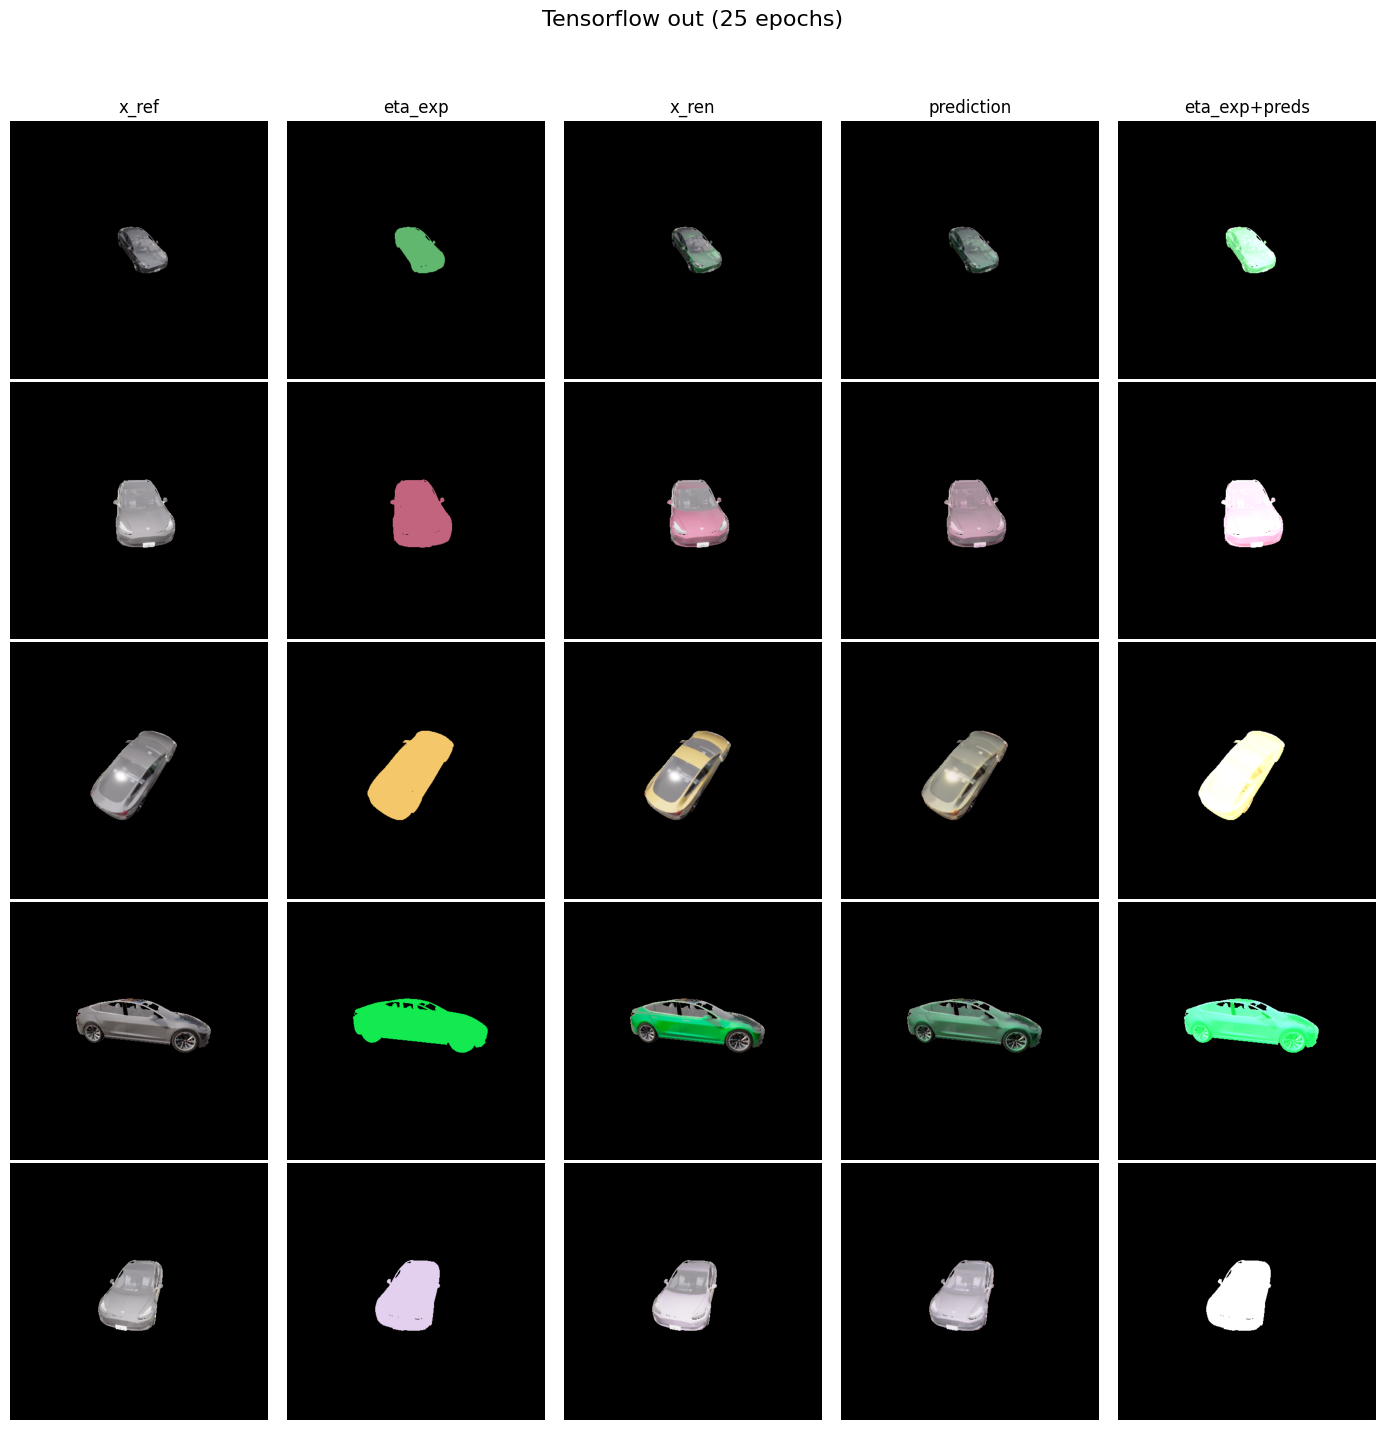

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

diff = eta_exp[1025:] + preds

# Intersection mask (where rendered and reference are the same)
# For floating point images, use np.isclose with a tolerance
#intersection = np.isclose(x_ren_ref_diff[1025:], x_ref[1025:], atol=1e-2)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "x_ren_ref_diff", "prediction", "eta_exp+preds"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        x_ren_ref_diff[i+1025],
        preds[i],
        diff[i],
  #     intersection[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (25 epochs)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## pytorch

### plain nn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


device = 'cpu'
print(f"Using {device} device")

In [ ]:
class Dtn(nn.Module):
    def __init__(self):
        super(Dtn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),  # 6 channels: x_ref + eta_exp
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB image
            nn.Sigmoid()  # Keep output in [0, 1]
        )

    def forward(self, x_ref, eta_exp):
        x = torch.cat([x_ref, eta_exp], dim=1)  # Concatenate along channels
        x = self.features(x)
        return x


In [ ]:
import glob
from PIL import Image
import torch
from torchvision import transforms
import numpy as np

# Image size
image_size = (500, 500)

# Define a common transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # Converts to tensor in [0,1]
])

# Get list of filenames
x_ref_paths = sorted(glob.glob("dataset/reference/*.png"))
eta_exp_paths = sorted(glob.glob("dataset/texture/*.png"))
x_ren_paths = sorted(glob.glob("dataset/rendered/*.png"))

# Load all images into lists (or torch tensors)
x_ref = [transform(Image.open(p).convert("RGB")) for p in x_ref_paths]
eta_exp = [transform(Image.open(p).convert("RGB")) for p in eta_exp_paths]
x_ren = [transform(Image.open(p).convert("RGB")) for p in x_ren_paths]

# Stack into full tensors
x_ref = torch.stack(x_ref)       # Shape: (N, 3, H, W)
eta_exp = torch.stack(eta_exp)   # Shape: (N, 3, H, W)
x_ren = torch.stack(x_ren)       # Shape: (N, 3, H, W)

x_ref, eta_exp, x_ren = x_ref.to(device), eta_exp.to(device), x_ren.to(device)

print("Loaded real datasets...")


In [ ]:
model = Dtn().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10


for epoch in range(num_epochs):
    model.train()
    preds = model(x_ref[:500], eta_exp[:500])
    loss = criterion(preds, x_ren[:500])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
model.eval()
with torch.no_grad():
    pred = model(x_ref[1025:], eta_exp[1025:]).cpu()

import matplotlib.pyplot as plt
import numpy as np

# Titles per column
titles = ['x_ref', 'eta_exp', 'x_ren', 'prediction']

# Plot: 5 rows × 4 columns
plt.figure(figsize=(14, 10))

for i in range(5):  # for 5 samples
    imgs = [x_ref[i+1025], eta_exp[i+1025], x_ren[i+1025], pred[i]]
    for j in range(4):  # for 4 image types
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(np.clip(imgs[j].permute(1, 2, 0).cpu().numpy(), 0, 1))
        ax.axis('off')
        if i == 0:
            ax.set_title(titles[j])

plt.suptitle("Pytorch out", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
